In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

import cv2
from cv2 import IMREAD_GRAYSCALE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201, ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, UpSampling2D, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping

In [2]:
# DataFrame[ первая колонка путь к картинке, вторая к маске], размер батча, путь к картинкамб путь к маскам

def keras_generator(gen_df, batch_size):     
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread(img_name)
            mask = cv2.imread(mask_rle, IMREAD_GRAYSCALE)
#             mask = imread(mask_rle)
#             img = imread(img_name)
#             mask = rle_decode(mask_rle)
#             mask = mask[:,:,0]
#             print("1:", mask.shape)
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
#             print("2:", mask.shape)
            x_batch += [img]
            y_batch += [mask]
        
        x_batch = np.array(x_batch) / 255
        y_batch = np.array(y_batch)
        
        yield x_batch, np.expand_dims(y_batch, -1)

# Data

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.head(3)

,imageid,maskid
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg


In [6]:
df["path_img"] = "data/images/images/" + df["imageid"]

In [7]:
df["path_gt"] = "data/masks/masks/" + df["maskid"]

In [8]:
df.head(2)

,imageid,maskid,path_img,path_gt
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,data/images/images/ID00007637202177411956430_0...,data/masks/masks/ID00007637202177411956430_mas...
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,data/images/images/ID00007637202177411956430_1...,data/masks/masks/ID00007637202177411956430_mas...


In [9]:
df_train = pd.DataFrame(columns = ["img", "mask"])
df_train["img"] =df["path_img"] 
df_train["mask"] =df["path_gt"]

In [10]:
df_train[:3]

,img,mask
0,data/images/images/ID00007637202177411956430_0...,data/masks/masks/ID00007637202177411956430_mas...
1,data/images/images/ID00007637202177411956430_1...,data/masks/masks/ID00007637202177411956430_mas...
2,data/images/images/ID00007637202177411956430_2...,data/masks/masks/ID00007637202177411956430_mas...


In [11]:
tr_s = int(df_train.shape[0]*0.8)
tr_s

train = df_train[:tr_s]
val = df_train[tr_s:]

In [12]:
train.shape, val.shape

((13366, 2), (3342, 2))

# Model DenseNet201

In [13]:
input_shape = (256, 256, 3)
LR = 0.0001

In [14]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)

In [15]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 64, 64, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 64, 64, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 64, 64, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 32, 32, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 32, 32, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 32, 32, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 32, 32, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 32, 32, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 32, 32, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 32, 32, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 32, 32, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 16, 16, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 16, 16, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 16, 16, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 16, 16, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 16, 16, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 16, 16, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 16, 16, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 16, 16, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 16, 16, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 16, 16, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 16, 16, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 16, 16, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 16, 16, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 16, 16, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 16, 16, 1024  0          ['conv4_block25_0_bn[0][0]']     
 on)      

 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 16, 16, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 16, 16, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block33_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 16, 16, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)                           )                                 'conv4_block33_2_conv[0][0]']   
          

                                                                                                  
 conv4_block37_concat (Concaten  (None, 16, 16, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 16, 16, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 16, 16, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_blo

 conv4_block42_0_relu (Activati  (None, 16, 16, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 16, 16, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 16, 16, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block46_1_relu (Activati  (None, 16, 16, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 16, 16, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 16, 16, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 16, 16, 1728  6912       ['conv4_block46_concat[0][0]']   
 lization)

                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 8, 8, 960)   0           ['conv5_block1_concat[0][0]',    
 te)      

 conv5_block6_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 8, 8, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 8, 8, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 8, 8, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block11_0_relu (Activati  (None, 8, 8, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 8, 8, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 8, 8, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_blo

 conv5_block19_concat (Concaten  (None, 8, 8, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 8, 8, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 8, 8, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 8, 8, 128)    192512      ['conv5_block20_0_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 8, 8, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 8, 8, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block28_1_relu (Activati  (None, 8, 8, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 8, 8, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 8, 8, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 8, 8, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 bn (BatchNormalization)        (None, 8, 8, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 8, 8, 1920)   0           ['bn[0][0]']                     
                                                                                                  
Total params: 18,321,984
Trainable params: 18,092,928
Non-trainable params: 229,056
__________________________________________________________________________________________________


In [16]:
base_out = base_model.output
base_out

<KerasTensor: shape=(None, 8, 8, 1920) dtype=float32 (created by layer 'relu')>

In [17]:
len(base_model.layers)

707

In [18]:
conv1 = base_model.get_layer("conv1/relu").output
conv2 = base_model.get_layer("pool2_relu").output
conv3 = base_model.get_layer("pool3_relu").output
conv4 = base_model.get_layer("pool4_relu").output
conv5 = base_model.get_layer("relu").output


inp = base_model.get_layer("input_1").output

In [19]:
conv1

<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv1/relu')>

In [20]:
conv2

<KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'pool2_relu')>

In [21]:
conv3

<KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'pool3_relu')>

In [22]:
conv4

<KerasTensor: shape=(None, 16, 16, 1792) dtype=float32 (created by layer 'pool4_relu')>

In [23]:
conv5

<KerasTensor: shape=(None, 8, 8, 1920) dtype=float32 (created by layer 'relu')>

In [24]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
up1

<KerasTensor: shape=(None, 16, 16, 1920) dtype=float32 (created by layer 'up_sampling2d')>

In [25]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3,3), padding="same")(conc_1)
conv_act_1 = Activation("relu")(conv_conc_1)
print(conv_act_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_act_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3,3), padding="same")(conc_2)
conv_act_2 = Activation("relu")(conv_conc_2)
print(conv_act_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_act_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3,3), padding="same")(conc_3)
conv_act_3 = Activation("relu")(conv_conc_3)
print(conv_act_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3,3), padding="same")(conc_4)
conv_act_4 = Activation("relu")(conv_conc_4)
print(conv_act_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3,3), padding="same")(up5)
conv_act_5 = Activation("sigmoid")(conv_conc_5)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='activation/Relu:0', description="created by layer 'activation'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='activation_1/Relu:0', description="created by layer 'activation_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='activation_2/Relu:0', description="created by layer 'activation_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='activation_3/Relu:0', description="created by layer 'activation_3'")


In [26]:
conv_act_5

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'activation_4')>

In [27]:
model = Model(inputs= base_model.input, outputs=conv_act_5, name= "mymodel")

In [28]:
# best_w = keras.callbacks.ModelCheckpoint("densnet_best.h5",
#                                        monitor="val_loss",
#                                        verbose=0,
#                                         save_best_only=True,
#                                         save_weights_only=True,
#                                         mode="auto",
#                                         save_freq=1
#                                        )
# last_w = keras.callbacks.ModelCheckpoint("densnet_last.h5",
#                                        monitor="val_loss",
#                                        verbose=0,
#                                         save_best_only=False,
#                                         save_weights_only=True,
#                                         mode="auto",
#                                         save_freq=1
#                                        )
# callbacks = [best_w, last_w]




In [29]:
# def dice_coef_(y_true, y_pred, smooth=100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice

In [30]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return 1 - dice_coef(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

Reduce_LR=ReduceLROnPlateau(monitor='val_loss',verbose=2,factor=0.5,min_lr=0.00001)
callback=[Reduce_LR]

adam = keras.optimizers.Adam(learning_rate=LR,
                             beta_1=0.9,
                             beta_2=0.999,
                             epsilon=1e-07)

model.compile(adam, bce_dice_loss,metrics=[iou, dice_coef])

In [31]:
# def dice_coef(y_true, y_pred):
#     smooth = 1.
# #     print(1)
#     y_true_f = K.flatten(y_true)
#     y_true_f = tf.cast(y_true_f, tf.float32)
# #     print("y_true_f: ",y_true_f)
# #     print("y_true_f_cast : ", tf.cast(y_true_f, tf.float32))
#     y_pred_f = K.flatten(y_pred)
# #     print("y_pred_f : ", y_pred_f)
# #     print("y_pred_f_cast : ", tf.cast(y_pred_f, tf.uint8))
#     intersection = K.sum(y_true_f * y_pred_f)
# #     print(2)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# # def bce_dice_loss(y_true, y_pred):
# #     return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

# def bce_dice_loss(y_true, y_pred):
#     return K.log(dice_coef(y_true, y_pred))

# # def bce_dice_loss(y_true, y_pred):
# #     return 1 - dice_coef(y_true, y_pred)

# adam = keras.optimizers.Adam(learning_rate=LR,
#                              beta_1=0.9,
#                              beta_2=0.999,
#                              epsilon=1e-07)

# model.compile(adam, bce_dice_loss)

In [32]:
from tensorflow.keras.utils import plot_model

In [33]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [34]:
# batch_size = 8

# hist = model.fit(keras_generator(train, batch_size),
#                     steps_per_epoch = 10,
#                     epochs = 25,
#                     verbose=1,
# #                     callbacks = callbacks,
#                     validation_data=keras_generator(val, batch_size),
#                     validation_steps=50,
#                     class_weight=None,
#                     max_queue_size=10,
#                     workers=1,
#                     use_multiprocessing=False,
#                     shuffle=True,
#                     initial_epoch=0
#                    )

In [35]:
batch_size = 8

hist = model.fit(keras_generator(train, batch_size),
                    validation_data=keras_generator(val, batch_size),
                    steps_per_epoch=500,
                    validation_steps=10,
                    epochs=20,
                    callbacks=callback
         )

Epoch 1/20
500/500 [==============================] - 3514s 7s/step - loss: -41662021632.0000 - iou: 4.6277 - dice_coef: 1.5926 - val_loss: -640169672704.0000 - val_iou: 5.5700 - val_dice_coef: 1.6453 - lr: 1.0000e-04
Epoch 2/20
229/500 [============>.................] - ETA: 31:29 - loss: -1234404638720.0000 - iou: 4.7848 - dice_coef: 1.5988

KeyboardInterrupt: 

In [ ]:
# model.save("segmentation_DenseNet201.h5")

In [ ]:
# loss = hist.history['loss']
# val_loss = hist.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# predict

(450, 600, 3)
(450, 600)


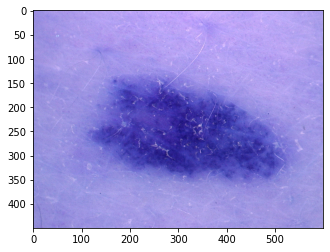

(<matplotlib.image.AxesImage at 0x1e68a7ca3c8>, None)

In [124]:
i, m =df_train.sample(1).values[0]
# mask = iio.imread(m)
# img = iio.imread(i)

# img.resize(256,256)

mask = cv2.imread(m, IMREAD_GRAYSCALE)
img = cv2.imread(i)

# mask = mask[:, :, 0]
print(img.shape)
print(mask.shape)
# plt.figure(figsize=(8, 8))
# plt.imshow(mask), plt.show()
plt.imshow(img), plt.show()

(1, 256, 256, 3)
1/1 [==============================] - 5s 5s/step


<function matplotlib.pyplot.show(close=None, block=None)>

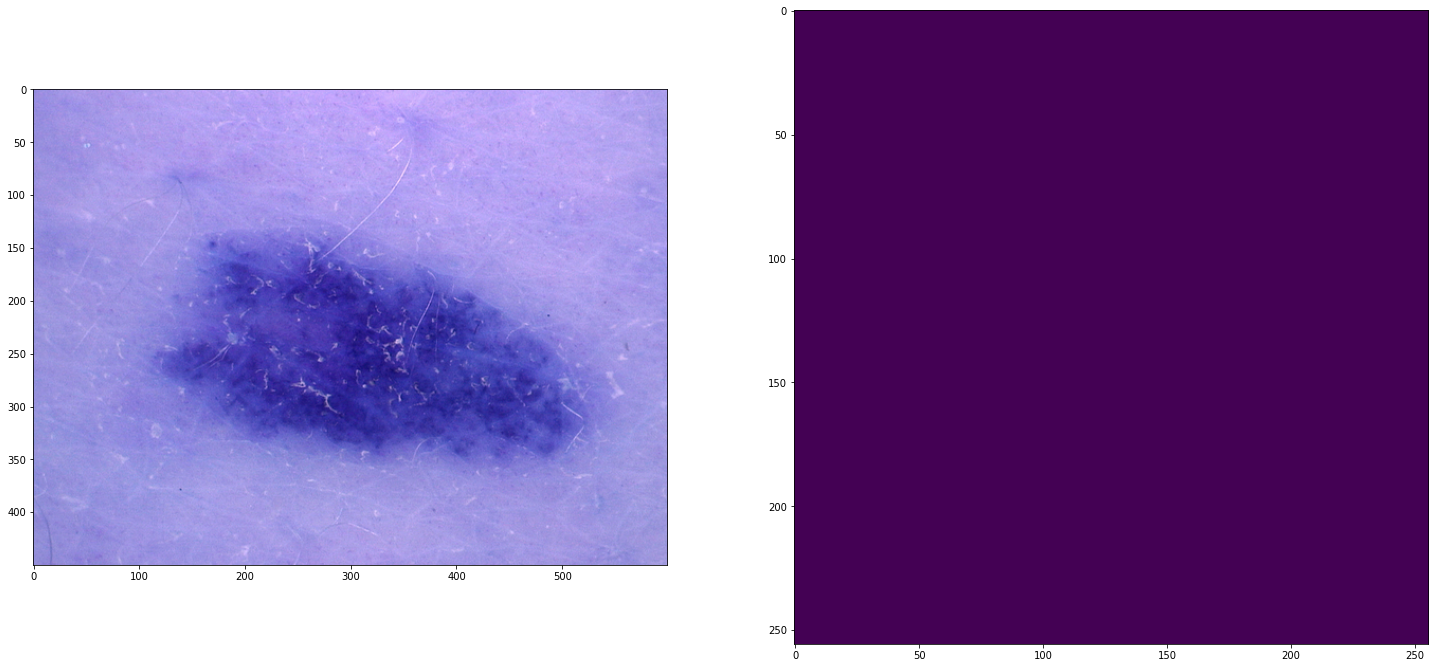

In [125]:
x= img
x = cv2.resize(x, (256,256))
x = x[None, ...]
print(x.shape)
pred = model.predict(x)

im_id = 5
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(img)
axes[1].imshow(pred[0,...,0] > 0.5)

plt.show

# Model VGG16

In [227]:
input_shape = (256, 256, 3)
LR = 0.0001

In [228]:
base_model_2 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [229]:
base_model_2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [230]:
base_out_2 = base_model_2.output
base_out_2

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [231]:
len(base_model_2.layers)

19

In [233]:
conv1 = base_model_2.get_layer("block2_conv2").output
conv2 = base_model_2.get_layer("block3_conv3").output
conv3 = base_model_2.get_layer("block4_conv3").output
conv4 = base_model_2.get_layer("block5_conv3").output
conv5 = base_model_2.get_layer("block5_pool").output




inp = base_model_2.get_layer("input_11").output

In [234]:
conv1

<KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>

In [235]:
conv2

<KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>

In [236]:
conv3

<KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block4_conv3')>

In [237]:
conv4

<KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'block5_conv3')>

In [238]:
conv5

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [239]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
up1

<KerasTensor: shape=(None, 16, 16, 512) dtype=float32 (created by layer 'up_sampling2d_61')>

In [240]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3,3), padding="same")(conc_1)
conv_act_1 = Activation("relu")(conv_conc_1)
print(conv_act_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_act_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3,3), padding="same")(conc_2)
conv_act_2 = Activation("relu")(conv_conc_2)
print(conv_act_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_act_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3,3), padding="same")(conc_3)
conv_act_3 = Activation("relu")(conv_conc_3)
print(conv_act_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3,3), padding="same")(conc_4)
conv_act_4 = Activation("relu")(conv_conc_4)
print(conv_act_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3,3), padding="same")(up5)
conv_act_5 = Activation("sigmoid")(conv_conc_5)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='activation_46/Relu:0', description="created by layer 'activation_46'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='activation_47/Relu:0', description="created by layer 'activation_47'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='activation_48/Relu:0', description="created by layer 'activation_48'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='activation_49/Relu:0', description="created by layer 'activation_49'")


In [241]:
model_2 = Model(inputs= base_model_2.input, outputs=conv_act_5, name= "mymodel")

In [242]:
best_w = keras.callbacks.ModelCheckpoint("densnet_best.h5",
                                       monitor="val_loss",
                                       verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode="auto",
                                        save_freq=1
                                       )
last_w = keras.callbacks.ModelCheckpoint("densnet_last.h5",
                                       monitor="val_loss",
                                       verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode="auto",
                                        save_freq=1
                                       )
callbacks = [best_w, last_w]




In [243]:
def dice_coef(y_true, y_pred):
    smooth = 1.
#     print(1)
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
#     print("y_true_f: ",y_true_f)
#     print("y_true_f_cast : ", tf.cast(y_true_f, tf.float32))
    y_pred_f = K.flatten(y_pred)
#     print("y_pred_f : ", y_pred_f)
#     print("y_pred_f_cast : ", tf.cast(y_pred_f, tf.uint8))
    intersection = K.sum(y_true_f * y_pred_f)
#     print(2)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

adam = keras.optimizers.Adam(learning_rate=LR,
                             beta_1=0.9,
                             beta_2=0.999,
                             epsilon=1e-07)

model_2.compile(adam, bce_dice_loss)

In [244]:
batch_size = 8

model_2.fit(keras_generator(train, batch_size),
                    steps_per_epoch = 10,
                    epochs = 25,
                    verbose=1,
#                     callbacks = callbacks,
                    validation_data=keras_generator(val, batch_size),
                    validation_steps=50,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0
                   )

Epoch 1/25
 5/10 [==============>...............] - ETA: 43s - loss: -2249.5837

KeyboardInterrupt: 

# predict model_2

In [ ]:
i, m =df_train.sample(1).values[0]
# mask = iio.imread(m)
# img = iio.imread(i)

# img.resize(256,256)

mask = cv2.imread(m, IMREAD_GRAYSCALE)
img = cv2.imread(i)

# mask = mask[:, :, 0]
print(img.shape)
print(mask.shape)
# plt.figure(figsize=(8, 8))
# plt.imshow(mask), plt.show()
plt.imshow(img), plt.show()

In [ ]:
x= img
x = cv2.resize(x, (256,256))
x = x[None, ...]
print(x.shape)
pred = model.predict(x)

im_id = 5
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(img)
axes[1].imshow(pred[0,...,0] > 0.5)

plt.show

# ResNet50

In [245]:
input_shape = (256, 256, 3)
LR = 0.0001

In [246]:
base_model_3 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

In [247]:
base_model_3.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [250]:
base_out = base_model_3.output
base_out

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [251]:
len(base_model_3.layers)

175

In [253]:
conv1 = base_model_3.get_layer("conv1_relu").output
conv2 = base_model_3.get_layer("conv2_block3_out").output
conv3 = base_model_3.get_layer("conv3_block4_out").output
conv4 = base_model_3.get_layer("conv4_block6_out").output
conv5 = base_model_3.get_layer("conv5_block3_out").output




inp = base_model_3.get_layer("input_12").output

In [254]:
conv1

<KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'conv1_relu')>

In [255]:
conv2

<KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'conv2_block3_out')>

In [256]:
conv3

<KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'conv3_block4_out')>

In [257]:
conv4

<KerasTensor: shape=(None, 16, 16, 1024) dtype=float32 (created by layer 'conv4_block6_out')>

In [258]:
conv5

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [259]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3,3), padding="same")(conc_1)
conv_act_1 = Activation("relu")(conv_conc_1)
print(conv_act_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_act_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3,3), padding="same")(conc_2)
conv_act_2 = Activation("relu")(conv_conc_2)
print(conv_act_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_act_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3,3), padding="same")(conc_3)
conv_act_3 = Activation("relu")(conv_conc_3)
print(conv_act_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3,3), padding="same")(conc_4)
conv_act_4 = Activation("relu")(conv_conc_4)
print(conv_act_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(1, (3,3), padding="same")(up5)
conv_act_5 = Activation("sigmoid")(conv_conc_5)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='activation_51/Relu:0', description="created by layer 'activation_51'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='activation_52/Relu:0', description="created by layer 'activation_52'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='activation_53/Relu:0', description="created by layer 'activation_53'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='activation_54/Relu:0', description="created by layer 'activation_54'")


In [260]:
model_3 = Model(inputs= base_model_3.input, outputs=conv_act_5, name= "mymodel")

In [261]:
best_w = keras.callbacks.ModelCheckpoint("densnet_best.h5",
                                       monitor="val_loss",
                                       verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode="auto",
                                        save_freq=1
                                       )
last_w = keras.callbacks.ModelCheckpoint("densnet_last.h5",
                                       monitor="val_loss",
                                       verbose=0,
                                        save_best_only=False,
                                        save_weights_only=True,
                                        mode="auto",
                                        save_freq=1
                                       )
callbacks = [best_w, last_w]




In [262]:
def dice_coef(y_true, y_pred):
    smooth = 1.
#     print(1)
    y_true_f = K.flatten(y_true)
    y_true_f = tf.cast(y_true_f, tf.float32)
#     print("y_true_f: ",y_true_f)
#     print("y_true_f_cast : ", tf.cast(y_true_f, tf.float32))
    y_pred_f = K.flatten(y_pred)
#     print("y_pred_f : ", y_pred_f)
#     print("y_pred_f_cast : ", tf.cast(y_pred_f, tf.uint8))
    intersection = K.sum(y_true_f * y_pred_f)
#     print(2)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

adam = keras.optimizers.Adam(learning_rate=LR,
                             beta_1=0.9,
                             beta_2=0.999,
                             epsilon=1e-07)

model_3.compile(adam, bce_dice_loss)

In [263]:
batch_size = 8

model_3.fit(keras_generator(train, batch_size),
                    steps_per_epoch = 10,
                    epochs = 25,
                    verbose=1,
#                     callbacks = callbacks,
                    validation_data=keras_generator(val, batch_size),
                    validation_steps=50,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0
                   )

Epoch 1/25
 2/10 [=====>........................] - ETA: 1:11 - loss: -144.3073

KeyboardInterrupt: 

# predict model_3

In [ ]:
i, m =df_train.sample(1).values[0]
# mask = iio.imread(m)
# img = iio.imread(i)

# img.resize(256,256)

mask = cv2.imread(m, IMREAD_GRAYSCALE)
img = cv2.imread(i)

# mask = mask[:, :, 0]
print(img.shape)
print(mask.shape)
# plt.figure(figsize=(8, 8))
# plt.imshow(mask), plt.show()
plt.imshow(img), plt.show()

In [ ]:
x= img
x = cv2.resize(x, (256,256))
x = x[None, ...]
print(x.shape)
pred = model.predict(x)

im_id = 5
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(img)
axes[1].imshow(pred[0,...,0] > 0.5)

plt.show

# U-Net

In [13]:
# Параметры модели
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
LR = 0.0001


smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

# def dice_coef_loss(y_true, y_pred):
#     return 1 - dice_coef(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac



In [14]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model_unet = build_model()

In [15]:
Reduce_LR=ReduceLROnPlateau(monitor='val_loss',verbose=2,factor=0.5,min_lr=0.00001)
callback=[Reduce_LR]

adam = keras.optimizers.Adam(learning_rate=LR,
                             beta_1=0.9,
                             beta_2=0.999,
                             epsilon=1e-07)

model_unet.compile(adam, bce_dice_loss,metrics=[iou, dice_coef])

In [16]:
batch_size = 8

hist = model_unet.fit(keras_generator(train, batch_size),
                    validation_data=keras_generator(val, batch_size),
                    steps_per_epoch=10,
                    validation_steps=10,
                    epochs=20,
                    callbacks=callback
         )

Epoch 1/20
10/10 [==============================] - 168s 17s/step - loss: 0.7155 - iou: 0.8384 - dice_coef: 0.9109 - val_loss: 0.4639 - val_iou: 0.8320 - val_dice_coef: 0.9041 - lr: 1.0000e-04
Epoch 2/20
10/10 [==============================] - 157s 16s/step - loss: -0.9266 - iou: 1.0942 - dice_coef: 1.0374 - val_loss: -6.6867 - val_iou: 2.2220 - val_dice_coef: 1.3605 - lr: 1.0000e-04
Epoch 3/20
10/10 [==============================] - 160s 16s/step - loss: -2704.8101 - iou: 4.8651 - dice_coef: 1.6247 - val_loss: -52810.8242 - val_iou: 4.4637 - val_dice_coef: 1.5664 - lr: 1.0000e-04
Epoch 4/20
10/10 [==============================] - 159s 16s/step - loss: -15779616.0000 - iou: 3.4944 - dice_coef: 1.4983 - val_loss: -159305328.0000 - val_iou: 5.1870 - val_dice_coef: 1.6286 - lr: 1.0000e-04
Epoch 5/20
10/10 [==============================] - 162s 17s/step - loss: -13514031104.0000 - iou: 4.6851 - dice_coef: 1.6121 - val_loss: -131910885376.0000 - val_iou: 5.3489 - val_dice_coef: 1.6395 -

KeyboardInterrupt: 

# predict

(512, 512, 3)
(512, 512)


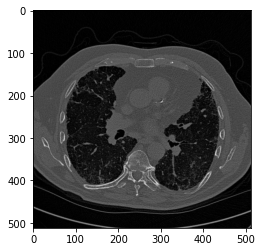

(<matplotlib.image.AxesImage at 0x1aa00136608>, None)

In [17]:
i, m =df_train.sample(1).values[0]
# mask = iio.imread(m)
# img = iio.imread(i)

# img.resize(256,256)

mask = cv2.imread(m, IMREAD_GRAYSCALE)
img = cv2.imread(i)

# mask = mask[:, :, 0]
print(img.shape)
print(mask.shape)
# plt.figure(figsize=(8, 8))
# plt.imshow(mask), plt.show()
plt.imshow(img), plt.show()

(1, 256, 256, 3)
1/1 [==============================] - 1s 1s/step


<function matplotlib.pyplot.show(close=None, block=None)>

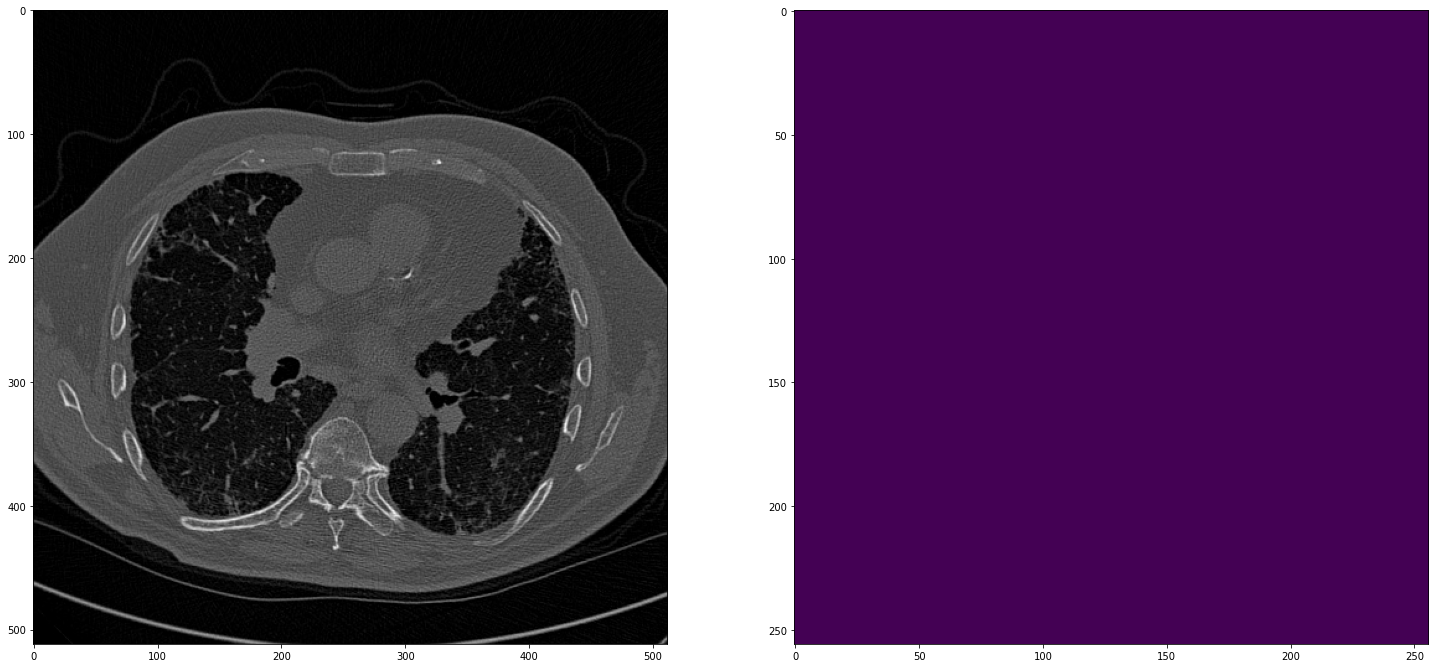

In [18]:
x= img
x = cv2.resize(x, (256,256))
x = x[None, ...]
print(x.shape)
pred = model_unet.predict(x)

im_id = 5
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(25,25))
axes[0].imshow(img)
axes[1].imshow(pred[0,...,0] > 0.5)

plt.show